In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
ntrain = data.shape[0]
ntest = test.shape[0]
y = data.Survived.values
passangerIds = test.PassengerId
all_data = pd.concat((data, test)).reset_index(drop=True)
# PassengerId and Ticket is identifier so we can drop them. Cabin has a lot of NaN values.
all_data.drop(['PassengerId', 'Ticket', 'Cabin', 'Name', 'Survived'], axis=1, inplace=True)

### NaN data

In [6]:
nan_data = all_data.isnull().sum()
nan_data.sort_values(ascending=False)

Age         263
Embarked      2
Fare          1
SibSp         0
Sex           0
Pclass        0
Parch         0
dtype: int64

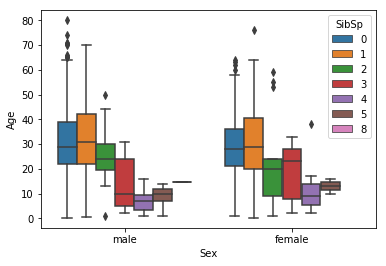

In [7]:
sns.boxplot(x='Sex', y='Age', hue='SibSp', data=all_data)

In [8]:
# Fill missing data in Age as mean in groupby sex and SibSp
all_data.Age = all_data.groupby(['Sex', 'SibSp']).transform(lambda x: x.fillna(x.mean()))
all_data.Age = all_data.groupby(['SibSp']).transform(lambda x: x.fillna(x.mean()))

In [9]:
all_data.groupby(['Embarked', 'Pclass'])['Fare'].mean()

Embarked  Pclass
C         1         106.845330
          2          23.300593
          3          11.021624
Q         1          90.000000
          2          11.735114
          3          10.390820
S         1          72.148094
          2          21.206921
          3          14.435422
Name: Fare, dtype: float64

In [10]:
all_data[all_data.Embarked.isna()][['Pclass', 'Fare']]

,Pclass,Fare
61,1,80.0
829,1,80.0


In [11]:
all_data = all_data.fillna({'Embarked': 'S'})

In [12]:
all_data.Fare = all_data.groupby(['Pclass', 'Embarked']).transform(lambda x: x.fillna(x.mean()))

### Create new features

In [13]:
all_data['FamilySize'] = all_data.SibSp + all_data.Parch + 1

In [14]:
all_data['IsAlone'] = (all_data.FamilySize == 1).astype(int)

In [15]:
all_data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,FamilySize,IsAlone
0,22.0,S,22.0,0,3,male,1,2,0
1,38.0,C,38.0,0,1,female,1,2,0
2,26.0,S,26.0,0,3,female,0,1,1
3,35.0,S,35.0,0,1,female,1,2,0
4,35.0,S,35.0,0,3,male,0,1,1


#### Categorical features

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [17]:
categorical_cols = ('Embarked', 'Sex')
encoder = LabelEncoder()
for col in categorical_cols:
    all_data[col] = encoder.fit_transform(all_data[col])

In [18]:
dummy_cols = ['Embarked', 'Sex', 'Pclass']
all_data = pd.get_dummies(data=all_data, columns=dummy_cols)

In [19]:
X = all_data[:ntrain]
test = all_data[ntrain:]

In [20]:
print(X.shape)
print(test.shape)

(891, 14)
(418, 14)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Features scaling

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Apply Feature selection

In [68]:
# As we can see below this is the linear problem, so we try to use PCA and LDA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=9)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [69]:
# pca.explained_variance_ratio_

array([ 0.26214486,  0.17811739,  0.14561359,  0.11774368,  0.09617351,
        0.07844065,  0.05572176,  0.03934113,  0.02670343])

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

### Try different classification model. Use Grid search to fit hyperparameters and improve classifiers

In [24]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
X = scaler.transform(X)
X = lda.transform(X)

In [26]:
# Calculate accuracy
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=lr_model, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuracy std: {accuracies.std()}')

Mean accuracy: 0.7991337532629667
Accuracy std: 0.02745355545342754


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lr_model.predict(X_test))

array([[93, 17],
       [20, 49]])

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# SVM
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C=1)
svc_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [30]:
accuracies = cross_val_score(estimator=svc_model, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuracy std: {accuracies.std()}')

Mean accuracy: 0.7991337532629667
Accuracy std: 0.02745355545342754


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, svc_model.predict(X_test))

array([[92, 18],
       [20, 49]])

In [36]:
parameters = [
    {'kernel': ['linear'],
     'C': [1, 10, 100, 150]},
    {'kernel': ['rbf'], 
     'C': [1, 10, 100, 150], 
     'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
]
grid = GridSearchCV(estimator=svc_model, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 150]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 150], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
grid.best_score_

0.78691275167785235

In [38]:
grid.best_params_

{'C': 100, 'kernel': 'linear'}

### !! Conclusion - this is a linear model!!

In [39]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=9, leaf_size=10)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [40]:
accuracies = cross_val_score(estimator=knn_model, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuract std: {accuracies.std()}')

Mean accuracy: 0.81593746453297
Accuract std: 0.021989771179424134


In [34]:
confusion_matrix(y_test, knn_model.predict(X_test))

array([[102,   8],
       [ 28,  41]])

In [37]:
parameters = [
    {
        'n_neighbors': [5, 6, 7, 8, 9, 10, 15, 10],
        'leaf_size': [5, 6, 7, 8, 9, 10, 20, 25, 30, 35, 40]
    }
]
grid = GridSearchCV(estimator=knn_model, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': [5, 6, 7, 8, 9, 10, 15, 10], 'leaf_size': [5, 6, 7, 8, 9, 10, 20, 25, 30, 35, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
print(grid.best_score_)
print(grid.best_params_)

0.813202247191
{'leaf_size': 10, 'n_neighbors': 9}


In [34]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_test, y_test)

GaussianNB(priors=None, var_smoothing=1e-09)

In [35]:
accuracies = cross_val_score(estimator=nb_model, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuracy std: {accuracies.std()}')

Mean accuracy: 0.7991337532629667
Accuracy std: 0.02745355545342754


In [36]:
confusion_matrix(y_test, nb_model.predict(X_test))

array([[93, 17],
       [20, 49]])

In [37]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
accuracies = cross_val_score(estimator=rf_model, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuracy std: {accuracies.std()}')

Mean accuracy: 0.7609930768357736
Accuracy std: 0.026565687597584927


In [42]:
parameters = [
    {'n_estimators': [10, 15, 20, 30, 40, 50]}
]
grid = GridSearchCV(estimator=rf_model, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 15, 20, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [43]:
print(grid.best_score_)
print(grid.best_params_)

0.762640449438
{'n_estimators': 40}


In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf_model.predict(X_test))

array([[90, 20],
       [20, 49]])

#### XGBoost

In [39]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
accuracies = cross_val_score(estimator=xgb, X=X, y=y, scoring='accuracy', cv=10)
print(f'Mean accuracy: {accuracies.mean()}')
print(f'Accuracy std: {accuracies.std()}')

Mean accuracy: 0.8148516059471117
Accuracy std: 0.02868025983392959


In [47]:
parameters = [
    {'max_depth': [2, 3, 5, 7, 10],
     'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }
]
grid = GridSearchCV(estimator=xgb, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [2, 3, 5, 7, 10], 'learning_rate': [0.01, 0.05, 0.1, 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [48]:
print(grid.best_score_)
print(grid.best_params_)

0.827247191011
{'learning_rate': 0.05, 'max_depth': 2}


In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf_model.predict(X_test))

array([[97, 13],
       [22, 47]])

### The best score in the XGBoost algorithm, use it to predict test data

In [41]:
X = all_data[:ntrain]
test = all_data[ntrain:]

In [42]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)
lda = LinearDiscriminantAnalysis(n_components=9)
X = lda.fit_transform(X, y)
test = lda.transform(test)

In [43]:
lr = LogisticRegression()
lr.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [44]:
pred_y = lr.predict(test)

In [45]:
sub = pd.DataFrame()
sub['PassengerId'] = passangerIds
sub['Survived'] = pred_y.astype(int)
sub.to_csv('gender_submission.csv',index=False)